# Cora Dataset Example

In this example, I am given the ground truth labels of a small subset of nodes and want to infer the labels for all of the remaining nodes.

The dataset used is the *Cora* dataset, which is a citation network where nodes represent documents. This dataset consists of 2708 scientific publications classified into one of seven classes. Each node is described by a 1433-dim bag of words feature vector. Two nodes (documents) are connected if there exists a citation link between them.

**The task is to infer the category of each document.**

In [30]:
# install necessary packages

%pip install torch_geometric # install pytorch geometric
%pip install torchvision #install torchvision
%pip install matplotlib #install matplotlib
%pip install graphviz # install graphviz

%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.explain import GNNExplainer,Explainer,GraphMaskExplainer,PGExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv
from torch.nn import Linear,Softmax
import os
from tqdm import tqdm, trange
import pickle

import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [31]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root = 'data/Planetoid', name='Cora', transform=NormalizeFeatures())
# the normalize features transformation row-normalizes the attributes to sum up functional name

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

#get the graph object in the Cora dataset
data = dataset[0]

print()
print("Information about dataset:")
print(data)
print("Here we can see that the data is formatted as a vector of 2708 rows for 2708 publications with 1433 columns with the bag of words vector")
print('===========================================================================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Information about dataset:
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Here we can see that the data is formatted as a vector of 2708 rows for 2708 publications with 1433 columns with the bag of words vector
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


As we can see, this dataset holds 2708 nodes with 10556 edges. We are given the ground truth categories of 140 nodes and therefore, have a training node label rate of 5%.

The `val_mask` and `test_mask` denote which nodes should be used for validation and testing.

We want to try to infer the category of the document solely based on its content (bag-of-words feature representation) without the relational information (edges).

## Training the GNN

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

The GCN Layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [32]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [33]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  # this performs a single forward pass
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  # ^ Compute the loss solely based on the training nodes.
  loss.backward() # derive gradients
  optimizer.step() # update parameters based on gradients
  return loss

def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
  return test_acc

for epoch in range(1, 101):
    loss = train()

## GNN Explainer

Now, I am going to try using GNN Explainer as an interpretability method on this node classification task.

In [34]:
from torch_geometric.explain import Explainer, GNNExplainer

"""
GNNEXPLAINER will generate an explanation by identifying a subgraph of the computation
graph and a subset of node features that are most influential for the model Φ’s prediction

Given a node v, our goal is to identify a subgraph GS ⊆ Gc and the associated features XS =
{xj |vj ∈ GS} that are important for the GNN’s prediction y

"""

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes', #  mask each node feature separately across all nodes
    edge_mask_type='object', # mask each edge
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

explanation = explainer(data.x, data.edge_index, index=10)

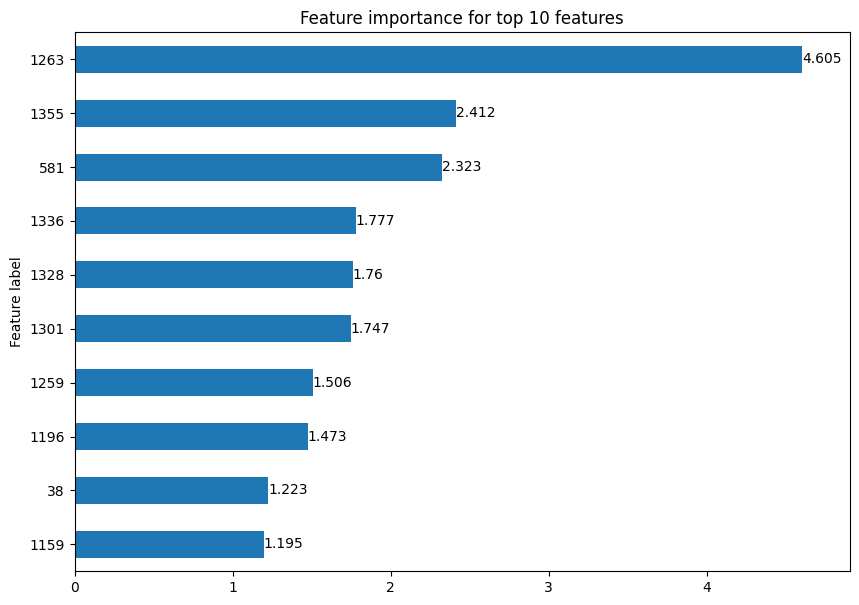

In [35]:
explanation.visualize_feature_importance(top_k=10)

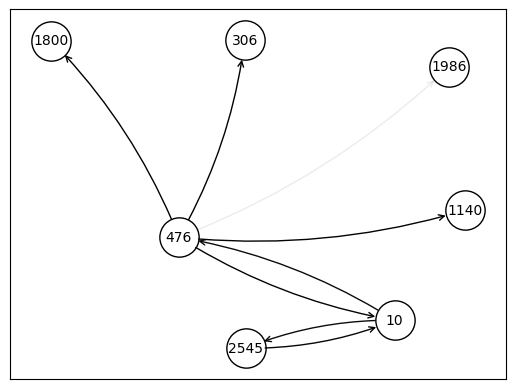

In [36]:
explanation.visualize_graph(backend='networkx')

In [37]:
"""
Fidelity evaluates the contribution of the produced explanatory subgraph to the initial prediction,
either by giving only the subgraph to the model (fidelity-) or by removing it from the entire graph (fidelity+).

Fidelity- close to 0 is good because it shows that the the explainer is better. The explanation given is quite sufficient.

The fidelity scores capture how good an explainable model reproduces the natural phenomenon or the GNN model logic.
Once we have produced an explanation we can obtain both fidelities as:
"""

from torch_geometric.explain.metric import fidelity, characterization_score

fid_pm = fidelity(explainer, explanation)
print(fid_pm)

(1.0, 0.0)


Now, I am going to try and play around with different parameters for gnn explainer. 


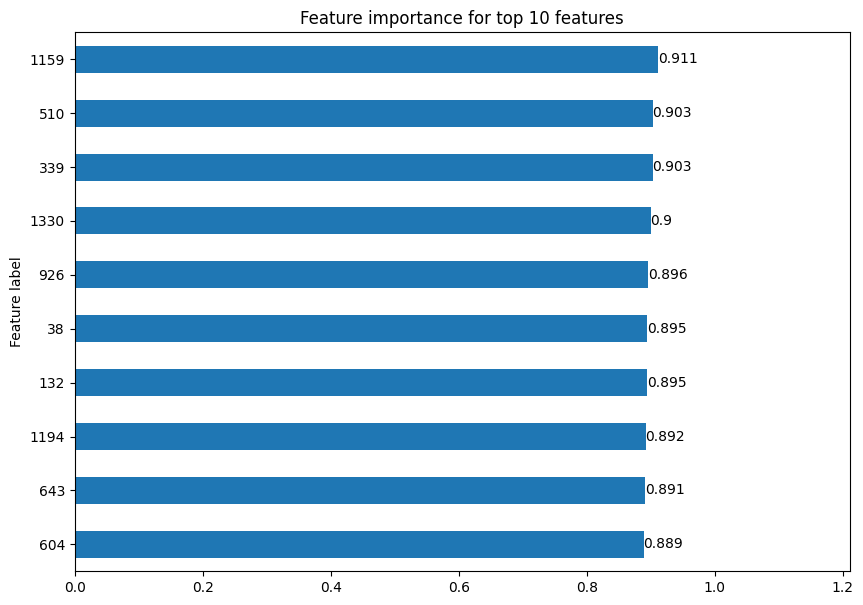

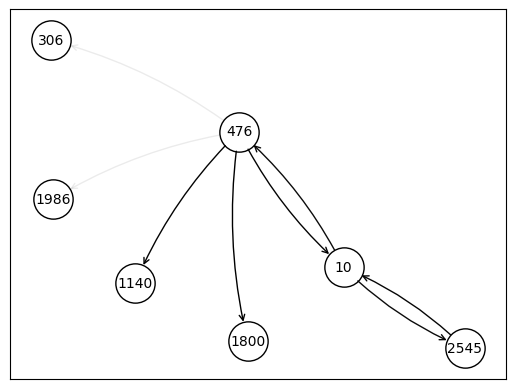

In [38]:
gnn_explainer2 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='common_attributes', #  change to common attributes
    edge_mask_type='object', 
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

"""
Originally, this configuration yielded an error. But it is working now which is interesting. 

Error Message: ValueError: Could not compute gradients for edges. Please make sure that edges are used via message passing inside the model or disable it via `edge_mask_type=None`.

Also, the feature importance changes slightly at each iteration. 
"""

gnn_explanation2 = gnn_explainer2(data.x, data.edge_index, index=10)
gnn_explanation2.visualize_feature_importance(top_k=10)
gnn_explanation2.visualize_graph(backend='networkx')

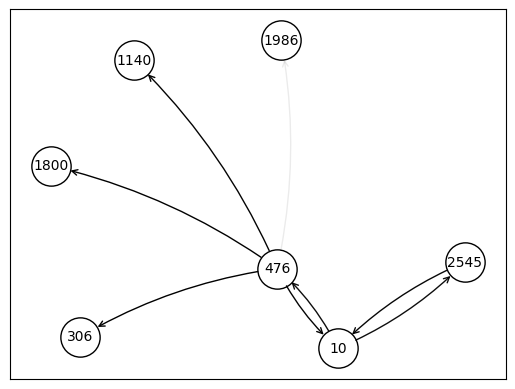

In [39]:
gnn_explainer3_1 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='object', #  change to object (NO feature masks, so no feature importance)
    edge_mask_type='object', # the edge mask in GNN Explainer needs to be either object or None (CANNOT be attributes or common attributes)
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

gnn_explanation3_1 = gnn_explainer3_1(data.x, data.edge_index, index=10)
gnn_explanation3_1.visualize_graph(backend='networkx')

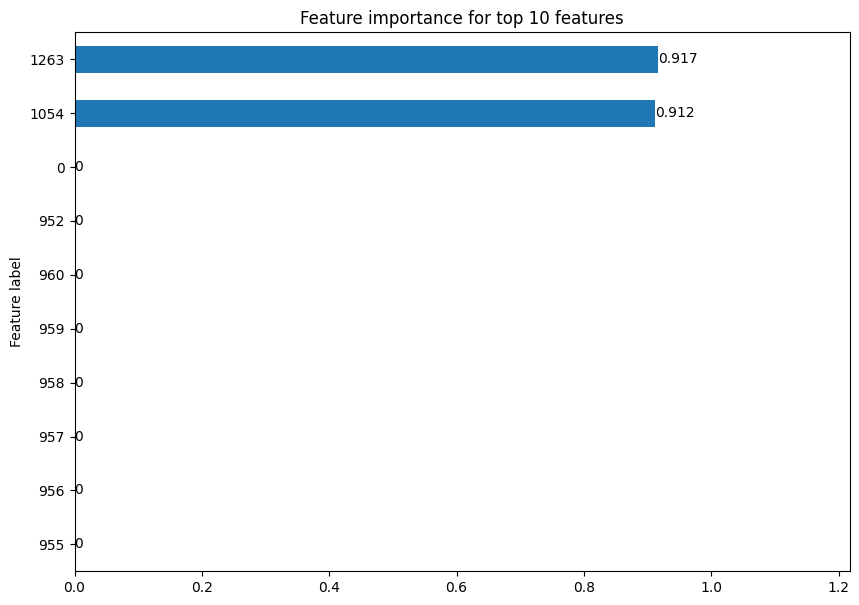

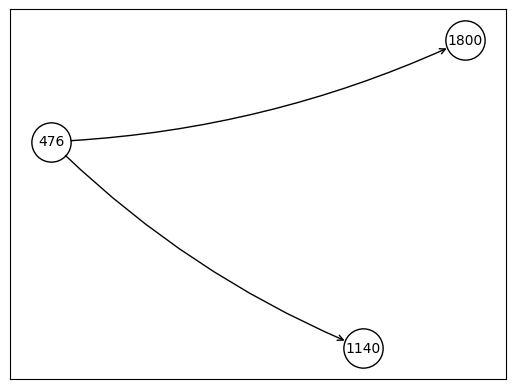

In [40]:
# Now, I am going to try keeping everything the same except I am going to add a threshold configuration

gnn_explainer4 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes', 
    edge_mask_type='object', 
    threshold_config=dict(
        threshold_type="topk", # A soft threshold is applied to each mask. The top obj:value elements of each mask are kept, the others are set to 0. 
        value=2 #Threshold Value is an integer -> how do I know what value to put here? 
    ),
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

gnn_explanation4 = gnn_explainer4(data.x, data.edge_index, index=10)
gnn_explanation4.visualize_feature_importance(top_k=10)
gnn_explanation4.visualize_graph(backend='networkx')

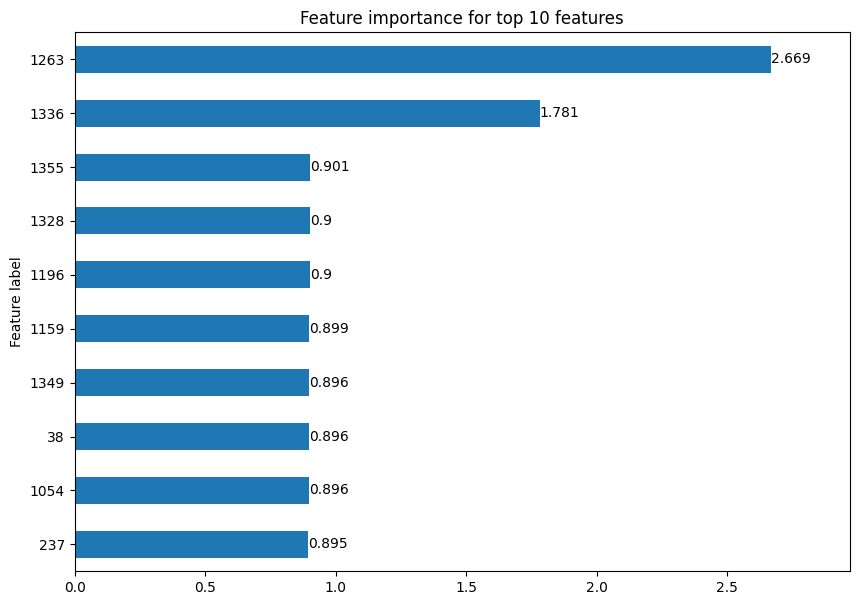

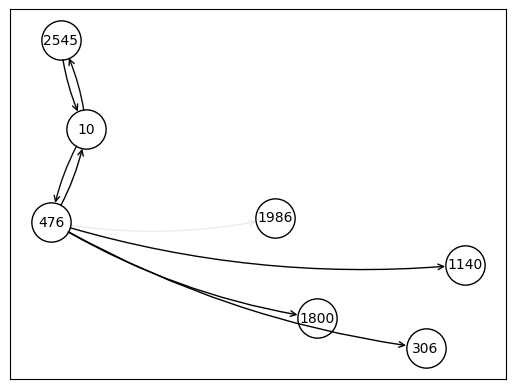

'\nAs the threshold increases, it seems like the features align with what we found originally. \n\nWhat does the value actually mean? \n'

In [41]:
gnn_explainer6 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes', 
    edge_mask_type='object', 
    threshold_config=dict(
        threshold_type="topk", 
        value=20 # higher threshold
    ),
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

gnn_explanation6 = gnn_explainer6(data.x, data.edge_index, index=10)
gnn_explanation6.visualize_feature_importance(top_k=10)
gnn_explanation6.visualize_graph(backend='networkx')

"""
As the threshold increases, it seems like the features align with what we found originally. 

What does the value actually mean? 
"""

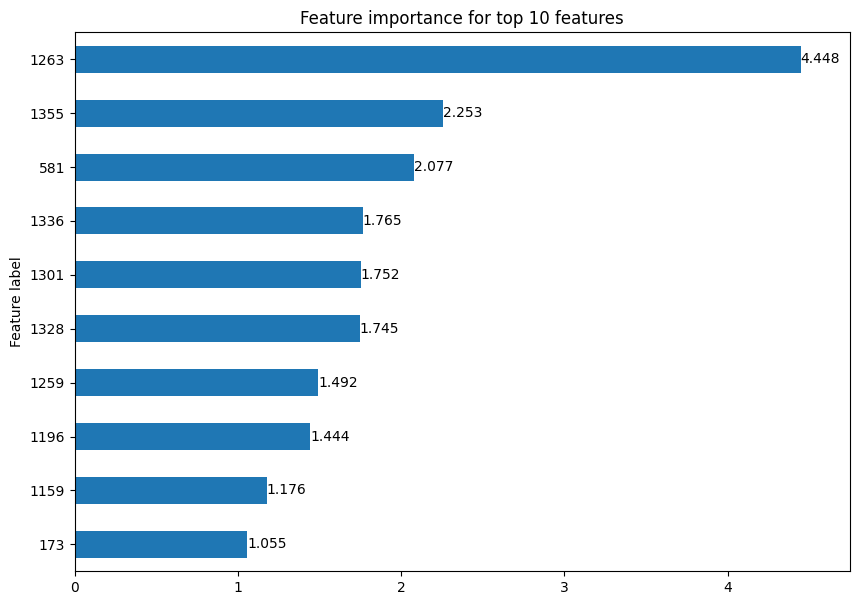

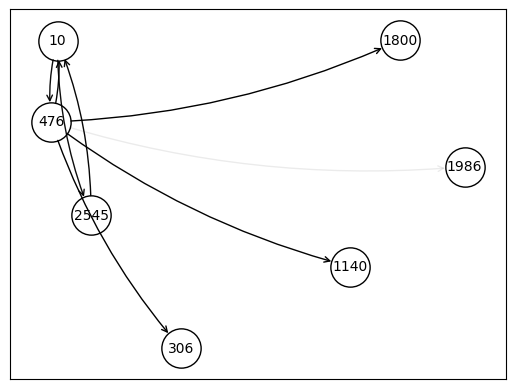

'\nAs the threshold increases, it seems like the features align with what we found originally. \n'

In [42]:
gnn_explainer7 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes', 
    edge_mask_type='object', 
    threshold_config=dict(
        threshold_type="topk", 
        value=50 #further increase threshold value
    ),
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

gnn_explanation7 = gnn_explainer7(data.x, data.edge_index, index=10)
gnn_explanation7.visualize_feature_importance(top_k=10)
gnn_explanation7.visualize_graph(backend='networkx')

"""
As the threshold increases, it seems like the features align with what we found originally. 
"""


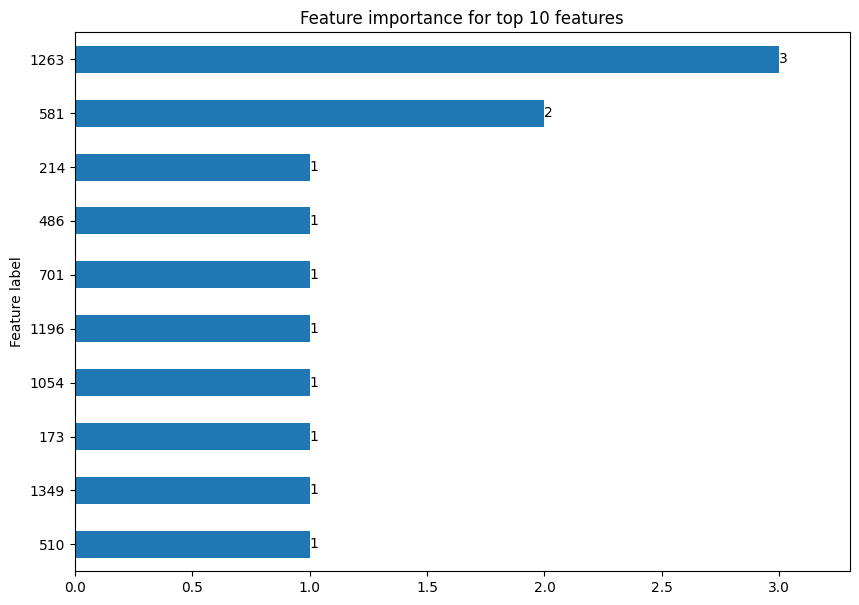

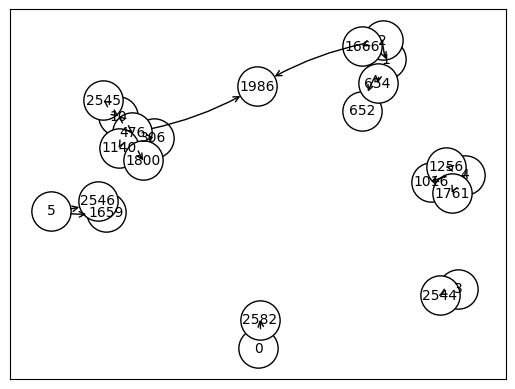

'\nThe feature importance is now shown in whole numbers - what does that mean? \n\nThe graph is also different and more complex ? \n'

In [43]:
gnn_explainer8 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes', 
    edge_mask_type='object', 
    threshold_config=dict(
        threshold_type='topk_hard', # Same as "topk" but values are set to 1 for all elements which are kept.
        value=20 #further increase threshold value
    ),
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

gnn_explanation8 = gnn_explainer8(data.x, data.edge_index, index=10)
gnn_explanation8.visualize_feature_importance(top_k=10)
gnn_explanation8.visualize_graph(backend='networkx')

"""
The feature importance is now shown in whole numbers - what does that mean? 

The graph is also different and more complex ? 
"""


In [45]:

nums = []
for i in range(0, 25):
    nums.append(i)

explanation_types = [explainer, gnn_explainer2, gnn_explainer3_1, gnn_explainer4, gnn_explainer6, gnn_explainer7, gnn_explanation8]
captions = ["--- Explanation 1 with 'default' settings ---", 
            "--- Explanation 2 with node = common attributes settings ---",
            "--- Explanation 3 with node = object settings ---",
            "--- Explanation 4 with threshold = top k with value of 2 ---",
            "--- Explanation 6 with threshold = top k with value of 20 ---",
            "--- Explanation 7 with threshold = top k with value of 50 ---", 
            "--- Explanation 8 with threshold = top k hard with value of 20 ---"]

for i in range(0, len(captions)):
    print(captions[i])
    explanation_metrics = explanation_types[i](data.x, data.edge_index, index=torch.tensor(nums))
    print(f'Generated explanations in {explanation_metrics.available_explanations}')

    fid_pm = fidelity(explainer, explanation_metrics)
    print("Fidelity:", fid_pm)

    try:
        char_score = characterization_score(fid_pm[0], fid_pm[1])
        print("Characterization score:", char_score)
    except:
        print("Unable to computer char score due to division by 0")






--- Explanation 1 with 'default' settings ---
Generated explanations in ['edge_mask', 'node_mask']
Fidelity: (0.6000000238418579, 0.19999998807907104)
Characterization score: 0.6857143056635953
--- Explanation 2 with node = common attributes settings ---
Generated explanations in ['edge_mask', 'node_mask']
Fidelity: (0.7200000286102295, 0.24000000953674316)
Characterization score: 0.7394594700341677
--- Explanation 3 with node = object settings ---
Generated explanations in ['edge_mask', 'node_mask']
Fidelity: (0.5600000023841858, 0.2799999713897705)
Characterization score: 0.6300000124610958
--- Explanation 4 with threshold = top k with value of 2 ---
Generated explanations in ['edge_mask', 'node_mask']
Fidelity: (0.0, 0.8799999952316284)
Unable to computer char score due to division by 0
--- Explanation 6 with threshold = top k with value of 20 ---
Generated explanations in ['edge_mask', 'node_mask']
Fidelity: (0.0, 0.8799999952316284)
Unable to computer char score due to division by

TypeError: Data.__call__() got an unexpected keyword argument 'index'

## PG Explainer

Next, we will try to use PGExplainer.

In [ ]:
from torch_geometric.explain import PGExplainer, ModelConfig

pg_explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

# Train against a variety of node-level or graph-level predictions:
for epoch in range(30): # Indices to train against.
        loss = pg_explainer.algorithm.train(epoch, model, data.x, data.edge_index,
                                         target=data.y, index=10)
# Get the final explanations:
pg_explanation = pg_explainer(data.x, data.edge_index, target=data.y, index=10)
print(f'Generated explanations in {pg_explanation.available_explanations}')

Generated explanations in ['edge_mask']


(0.0, 1.0)


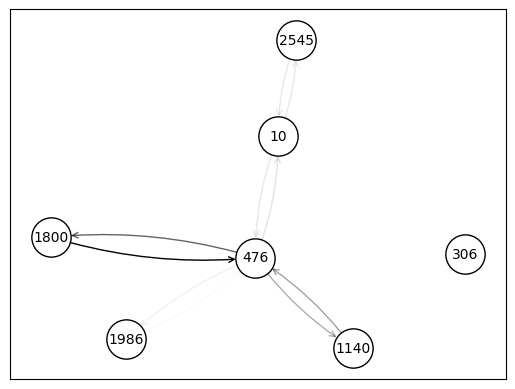

In [ ]:
fid = fidelity(explanation=pg_explanation, explainer=pg_explainer)
print(fid)
pg_explanation.visualize_graph(backend='networkx')

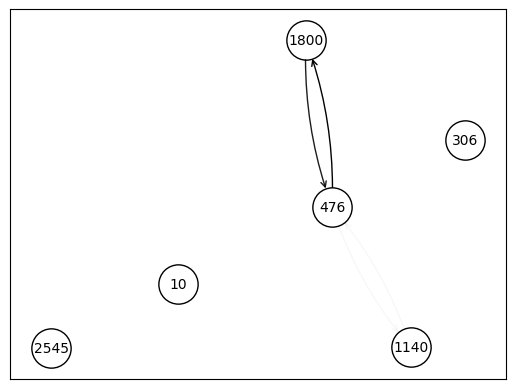

Generated explanations in ['edge_mask']


AttributeError: 'Explainer' object has no attribute 'get'

In [ ]:
# try training over multiple indices

pg_explainer2 = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon', #node mask type always has to be object because does not look at node features
    node_mask_type=None, 
    edge_mask_type='object', # can only do object for edges because edges do not have features in this example
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

# Train against a variety of node-level or graph-level predictions:
for epoch in range(30): # Indices to train against.
        for index in [2, 4, 6, 8, 10]:
            loss = pg_explainer2.algorithm.train(epoch, model, data.x, data.edge_index,
                                         target=data.y, index=index)
# Get the final explanations:
pg_explanation2 = pg_explainer2(data.x, data.edge_index, target=data.y, index=10)
pg_explanation2.visualize_graph(backend='networkx')

print(f'Generated explanations in {pg_explanation2.available_explanations}')

fid_pm = fidelity(explainer, pg_explainer2)
print("Fidelity:", fid_pm)

char_score = characterization_score(fid_pm[0], fid_pm[1])
print("Characterization score:", char_score)

Generated explanations in ['edge_mask']


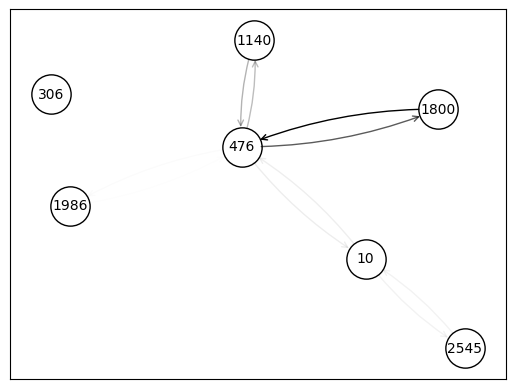

In [ ]:
pg_explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type='topk', # Same as "topk" but values are set to 1 for all elements which are kept.
        value=20 #further increase threshold value
    ),
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

# Train against a variety of node-level or graph-level predictions:
for epoch in range(30): # Indices to train against.
        loss = pg_explainer.algorithm.train(epoch, model, data.x, data.edge_index,
                                         target=data.y, index=10)
# Get the final explanations:
pg_explanation = pg_explainer(data.x, data.edge_index, target=data.y, index=10)
print(f'Generated explanations in {pg_explanation.available_explanations}')
pg_explanation.visualize_graph(backend='networkx')

## GraphMask

Now, we will try to use GraphMask Explainer.

In [ ]:
from torch_geometric.explain import GraphMaskExplainer

gm_explainer = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

node_index = 10
gm_explanation = gm_explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {gm_explanation.available_explanations}')

Train explainer for node(s) tensor([10]) with layer 1: 100%|██████████| 5/5 [00:00<00:00, 17.70it/s]
Train explainer for node(s) tensor([10]) with layer 0: 100%|██████████| 5/5 [00:00<00:00, 25.66it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 380.23it/s]

Generated explanations in ['edge_mask', 'node_mask']


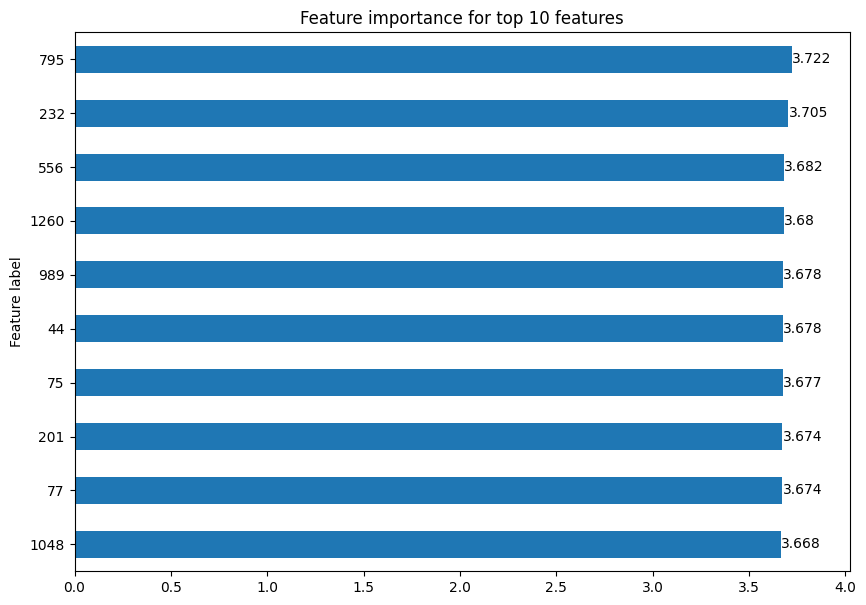

In [ ]:
gm_explanation.visualize_feature_importance(top_k=10)

In [ ]:
# try to get fidelity for overall fit
gm_explanation2 = gm_explainer(data.x, data.edge_index, index=torch.tensor([2, 4, 6, 8, 10]))

fid = fidelity(explainer=gm_explainer, explanation=gm_explanation2)
print(fid)


Train explainer for node(s) tensor([ 2,  4,  6,  8, 10]) with layer 1: 100%|██████████| 5/5 [00:00<00:00, 21.38it/s]
Train explainer for node(s) tensor([ 2,  4,  6,  8, 10]) with layer 0: 100%|██████████| 5/5 [00:00<00:00, 27.81it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 419.81it/s]


(0.0, 0.0)


Train explainer for node(s) tensor([10]) with layer 1: 100%|██████████| 5/5 [00:00<00:00, 63.17it/s]
Train explainer for node(s) tensor([10]) with layer 0: 100%|██████████| 5/5 [00:00<00:00, 69.00it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 408.64it/s]


Generated explanations in ['edge_mask', 'node_mask']


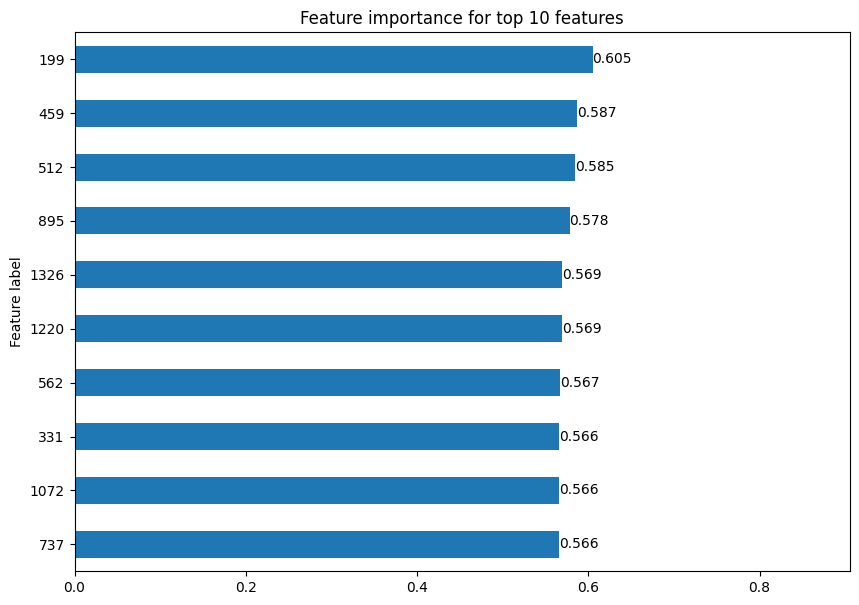

KeyboardInterrupt: 

In [ ]:
gm_explainer3 = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='common_attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

node_index = 10
gm_explanation3 = gm_explainer3(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {gm_explanation3.available_explanations}')

gm_explanation3.visualize_feature_importance(top_k=10)
gm_explanation3.visualize_graph()

  0%|          | 0/5 [00:00<?, ?it/s]

Train explainer for node(s) tensor([10]) with layer 1: 100%|██████████| 5/5 [00:00<00:00, 41.90it/s]
Train explainer for node(s) tensor([10]) with layer 0: 100%|██████████| 5/5 [00:00<00:00, 59.63it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 374.52it/s]


Generated explanations in ['edge_mask', 'node_mask']


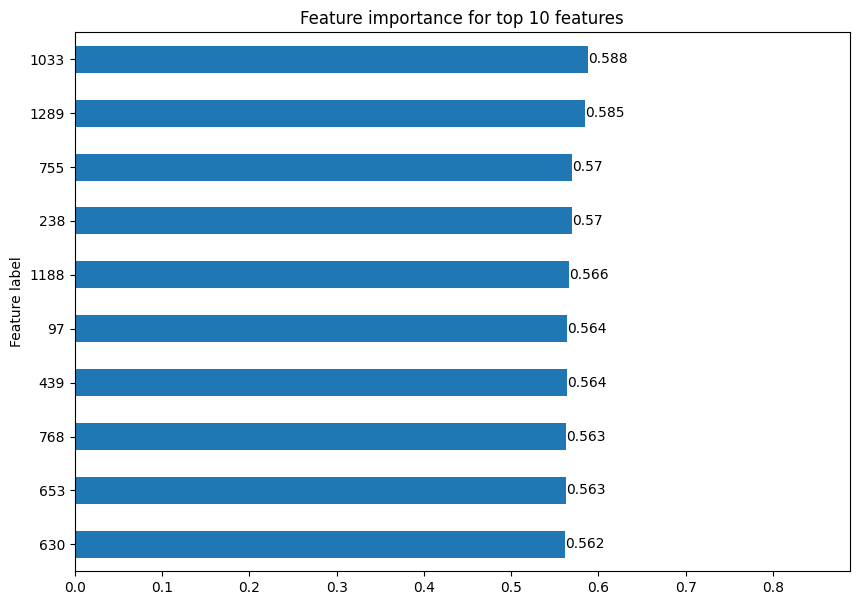

In [ ]:
gm_explainer4 = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='common_attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type='topk_hard', # Same as "topk" but values are set to 1 for all elements which are kept.
        value=5 #further increase threshold value
    ),
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

node_index = 10
gm_explanation4 = gm_explainer4(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {gm_explanation3.available_explanations}')

gm_explanation3.visualize_feature_importance(top_k=10)